# Bayesian Model Selection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import scipy.stats
from sklearn import mixture

We will be using MCMC for our Bayesian model evaluations, so we include the MCMC helper functions we had before in our [MCMC notebook](https://illinois-ipaml.github.io/MachineLearningForPhysics/_sources/lectures/MarkovChainMonteCarlo.html)

In [2]:
import functools
import inspect
import emcee

def wrap(func, **kwargs):
    """Prepare an arbitrary function to use with emcee sampling.

    Emcee expects its parameters in a single list, but it is sometimes more
    convenient to write a function in terms of named parameters and
    hyperparameters. This method uses introspection to wrap an arbitrary
    function with named parameters so that it has the signature expected
    by emcee.

    For example:

        def f(x,y,a,b): ...
        wrap(f, x=[1], y=[2], a=3, b=4, c=3, d=4)

    returns a tuple (wrapped, ['x','y'], [1,2], {'c':3, 'd':4}) where:

      - wrapped([p,q]) calls f(x=p,y=q,a=3,b=4)
      - [1,2] are the initial values to use for parameters named ['x','y'].
      - {'c':3, 'd':4} are the input kwargs with args of f() removed.

    The square brackets identify floating arguments and specify their initial
    value. An optional callable to evaluate a log-prior can also be passed,
    for example:

        wrap(f, x=[1,px], y=[2,py], a=3, b=4, c=3, d=4)

    where px(x) and py(y) return the (un-normalized) log of the priors on
    x and y to use during posterior sampling.

    Parameters
    ----------
    func : callable
        The function that should be prepared. It is assumed to have only
        numerical arguments that accept any floating point values.
    **kwargs : keyword arguments
        All arguments of func must be included and assigned a value.
        Arguments assigned a floating point value are considered fixed
        during sampling.  Arguments assigned a floating point value
        within a list, e.g., [1.2], will be sampled using the initial
        value provided.  Sampled arguments can optionally also specify
        a log-prior distribution using, e.g. [1.2, lnprior], where lnprior
        is a function of the sampled argument that returns the log prior
        probability density (which does not need to be normalized).

    Returns
    -------
    tuple
        Tuple (wrapped, names, values, kwargs). See example above for details.
    """
    fixed = {}
    names, values, lnpriors = [], [], []
    funcsig = inspect.signature(func)
    try:
        funcargs = {name: kwargs[name] for name in funcsig.parameters}
    except KeyError:
        raise ValueError('Missing arguments.')
    bound = funcsig.bind(**funcargs)
    bound.apply_defaults()
    NoPrior = lambda x: 0.
    for name, value in bound.arguments.items():
        if isinstance(value, list):
            names.append(name)
            values.append(value.pop(0))
            lnpriors.append(value.pop(0) if value else NoPrior)
            if value:
                raise ValueError('Invalid syntax for argument {}.'.format(name))
        else:
            fixed[name] = value
    partial = functools.partial(func, **fixed)
    def wrapped(theta):
        if len(theta) != len(names):
            raise ValueError('expected list of {} values.'.format(len(names)))
        result = 0.
        for lnprior, value in zip(lnpriors, theta):
            result += lnprior(value)
            if not np.isfinite(result):
                # theta is not allowed by this prior.
                return -np.inf
        args = dict(zip(names, theta))
        result += partial(**args)
        return result
    # Remove function args from kwargs.
    for name in funcargs:
        kwargs.pop(name, None)
    return wrapped, names, values, kwargs


def sample(func, names, values, nwalkers=20, nsamples=1000, abs_rms=1e-4,
           frac_rms=1e-3, burnin=100, random_state=None):
    """Generate MCMC samples of the un-normalized PDF func() using emcee.

    Can be used standalone but intended to work with :func:`wrap`.

    Initial values for each walker are Gaussian samples centered on the
    input values with an RMS of max(abs_rms, frac_rms * values).

    Parameters
    ----------
    func : callable
        Evaluate the log PDF to sample. Passed a single list of parameter
        values. Can be prepared using :func:`wrap`.
    names : iterable
        List of names for each floating parameter.  Used to label columns
        in the returned DataFrame. Can be prepared using :func:`wrap`.
    values : iterable
        List of initial values for each floating parameter.  Used to center
        random initial values for each walker. Can be prepared using
        :func:`wrap`.
    nwalkers : int
        The number of emcee walkers to use.
    nsamples : int
        The total number of samples to return, after combining walkers
        and trimming initial burnin.
    abs_rms : float
        Used to set walker initial values.  See above for details.
    rel_rms : float
        Used to set walker initial values.  See above for details.
    burnin : int
        The number of samples to remove from each walker's chain.
    random_state : np.random.RandomState or None
        The random state to use for reproducible chains.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, using the inputs names for columns.
    """
    if random_state is None:
        random_state = np.random.RandomState()
    # Generate sampler starting points.
    ndim = len(names)
    values = np.array(values, float)
    initial = np.tile(values, (nwalkers, 1))
    rms = np.maximum(abs_rms, frac_rms * values)
    initial += rms * random_state.normal(size=(nwalkers, ndim))
    # Initialize and run sampler.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
    n_per_chain = 1 + nsamples // nwalkers + burnin
    sampler.run_mcmc(initial, n_per_chain, rstate0=random_state.get_state())
    # Remove burnin and return results in a DataFrame.
    chain = sampler.chain[:, burnin:].reshape(-1, ndim)[:nsamples]
    return pd.DataFrame(chain, columns=names)


def MCMC_sample(func, **kwargs):
    """Generate random samples from an un-normalized PDF.

    See :func:`wrap` and :func:`sample` for details.

    Parameters
    ----------
    func : callable
        Function to evaluate log(f(...)) where f(...) is proportional
        to the desired probability density.  Will be wrapped to
        determine which arguments are sampled and which are fixed.
    **kwargs : keyword arguments
        Used to configure the wrapping of func and the sampler.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, with one named column per
        sampled argument of the input function.
    """
    # Wrap the input function.
    wrapped, names, values, kwargs = wrap(func, **kwargs)
    # Generate emcee samples.
    return sample(wrapped, names, values, **kwargs)

## <span style="color:Orange">Bayesian Model Selection</span>

We [originally stated](https://illinois-mlp.github.io/MachineLearningForPhysics/_sources/lectures/BayesianInference.html) Bayes' learning rule as:

$$ \Large
P(\Theta_M\mid D, M) = \frac{P(D\mid \Theta_M, M)\,P(\Theta_M\mid M)}{P(D\mid M)}
$$

in terms of the:
 1. ___<span style="color:Violet">Posterior</span>___: $P(\Theta_M\mid D, M)$ is the probability of the parameter values $\Theta_M$ given the data and the choice of hyperparameters.

 2.  ___<span style="color:Violet">Likelihood</span>:___ $P(D\mid \Theta_M, M)$ is the probability of the data given the model.

 3.  ___<span style="color:Violet">Prior</span>:___ $P(\Theta_M\mid M)$ is the probability of the model parameters given the hyperparameters and *marginalized over all possible data*.

 4.  ___<span style="color:Violet">Evidence</span>___: $P(D\mid M)$ is the probability of the data given the hyperparameters and *marginalized over all possible parameter values given the hyperparameters*.

We often omit the model $M$ in our notation when we are only considering a single model. However, unless there is only one possible model, then we still have to solve a meta-inference problem of comparing possible models. Although this step is often referred to as "<span style="color:Violet">model selection</span>", it is better to think of it as  ___<span style="color:Violet">model comparison</span>___, since it can only assign relative probabilities to different models.

Recalling <span style="color:Violet">Bayes' Rule</span> (see [Probability](https://illinois-mlp.github.io/MachineLearningForPhysics/_sources/lectures/ProbabilityTheory.html)), The posterior probability of a model $M$ given the observed data $D$ is:

$$ \Large
P(M\mid D) = \frac{P(D\mid M)\,P(M)}{P(D)} \; ,
$$

where the "evidence" given $M$, $P(D\mid M)$, is now in the numerator, and the denominator is now a "<span style="color:Violet">super evidence</span>":

$$ \Large
P(D) = \int dM\, P(D\mid M)\,P(M) \; .
$$

In case of a countable (perhaps infinite) set of possible models, the integral becomes a sum,

$$ \Large
P(D) = \sum_k \, P(D\mid M_k)\, P(M_k) \; ,
$$

and each "model likelihood" $P(D\mid M_k)$ is a probability in the range $[0,1]$. We have also introduced a prior $P(M)$ on the model itself, marginalized over its parameter space:

$$ \Large
P(M) = \int d\Theta_M\, P(\Theta_M, M) \; .
$$

Note the similarity between this "Bayes' rule for models" and the original Bayes' rule.

We can now anticipate two problems for practical model comparisons:
 - We were able to perform inference for a given model without ever calculating its evidence $P(D\mid M)$, but that is no longer possible for model comparison.

 - To calculate the "super evidence" we must be able to specify *all possible models*.
 
However, we can sidestep the second problem if we only want to compare two possible models, $M_1$ and $M_2$, without specifying (or perhaps even knowing) the set of possible models. We use the  ___<span style="color:Violet">odds ratio</span>___ for this comparison,

$$ \Large
\boxed{
\text{odds ratio =}\quad
\frac{P(M_1\mid D)}{P(M_2\mid D)} = \frac{P(D\mid M_1)\, P(M_1)}{P(D\mid M_2)\,P(M_2)} \;
}
$$

where, conveniently, the "super evidence" $P(D)$ cancels in the ratio. The ratio of "model likelihoods" appearing on the right-hand side is known as the <span style="color:Violet">Bayes factor</span>:

$$ \Large
\boxed{
\text{Bayes factor =}\quad
\frac{P(D\mid M_1)}{P(D\mid M_2)} \;
}
$$

It is easy to lose sight of the big picture with all of this probability calculus, so let's zoom out to a simple example:

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/ModelSelection-OccamFactor.jpg" width=800></img>
</div>

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">DISCUSS</span>___ Study the observed image $D$ above with two models in mind:
 - $M_1$: The image shows a single piece of paper.

 - $M_2$: The image shows two pieces of paper.

Are both models possible? Give some arguments for why $M_2$ is unlikely. Are your arguments based on prior knowledge?

Both models are certainly possible since the ruler could be hiding the fact that these are two pieces of paper side by side.

However, $M_2$ is unlikely because:
 - This looks like a standard (US) sheet of paper, as supported its dimensions according to the ruler.

 - It would be a remarkable coincidence for two sheets of paper to be perfectly lined up like this.
 
The first argument is based on our prior knowledge, such as:
 - Standard (US) paper has the proportions 8.5 to 11.

 - Most (US) rulers are in inches.
 
Therefore, this type of argument shows up in the ratio of model priors, $P(M_1) / P(M_2)$ in the odds ratio above.
 
However, the second argument is a statement about probabilities that does not rely on any prior knowledge. Instead, it shows up in the Bayes factor above. To see how this happens, we need to define the parameters for each model. For each piece of paper, use four parameters:
 - $(x,y)$ of the top-left corner, which could be anywhere in the image.

 - width $w$ and height $h$ of the paper, which range over the full image width and height.
 
The likelihoods of $M_1$ and $M_2$ are then integrals over four and eight parameters, respectively:

$$ \Large
P(D\mid M_i) = \int d\Theta_i\, P(D, \Theta_i\mid M_i) \; .
$$

For $M_2$, the likelihood of the observed image $D$ will be zero except when the parameters of the second piece of paper have it line up perfectly under the ruler. Since this represents a small fraction of the full range of $M_2$ parameters, $P(D\mid M_2)$ is heavily penalized compared with $P(D\mid M_1)$, leading to a large Bayes factor.

This is an example of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor) in action: Bayesian inference prefers the simplest explanation (model), independently of any prior knowledge.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

## <span style="color:Orange">Case Study: How Many Peaks?</span>

Generate some random samples of a single feature $x$ drawn from a mixture of two Gaussians:

In [3]:
def generate_mix(n_total, frac1, mu1, mu2, sigma1, sigma2, seed=123, plot_range=(-1.5, 1.5)):
    gen = np.random.RandomState(seed=seed)
    # Assign each sample to one of the peaks.
    idx = scipy.stats.bernoulli.rvs(1 - frac1, size=n_total, random_state=gen)
    # Set the Gaussian parameters for each sample.
    mu = np.array([mu1, mu2])[idx]
    sigma = np.array([sigma1, sigma2])[idx]
    # Generate each sample.
    X = scipy.stats.norm.rvs(mu, sigma, random_state=gen)
    # Optional plot.
    if plot_range:
        bins = np.linspace(*plot_range, 30)
        plt.hist(X, bins, histtype='stepfilled', alpha=0.5, density=True)
        plt.hist(X, bins, histtype='step', color='k', lw=1, density=True)
        grid = np.linspace(*plot_range, 201)
        if frac1 > 0:
            pdf1 = scipy.stats.norm.pdf(grid, mu1, sigma1)
            plt.plot(grid, frac1 * pdf1, lw=2)
        if frac1 < 1:
            pdf2 = scipy.stats.norm.pdf(grid, mu2, sigma2)
            plt.plot(grid, (1 - frac1) * pdf2, lw=2)
        plt.show()
    return X

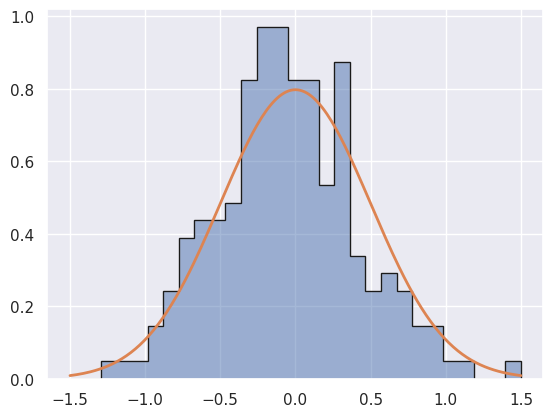

In [4]:
n_gen = 200
Da = generate_mix(n_gen, 1.0, 0.0, np.nan, 0.5, np.nan) # nan values are never used

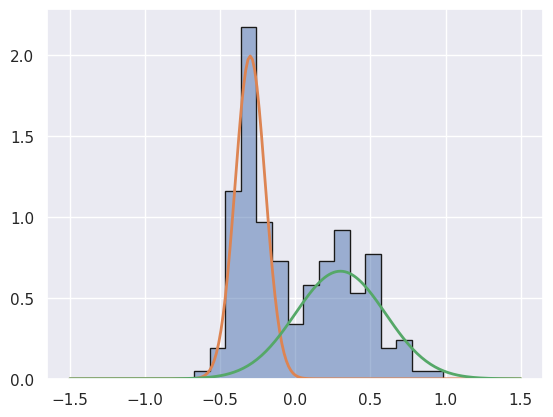

In [5]:
Db = generate_mix(n_gen, 0.5, -0.3, 0.3, 0.1, 0.3)

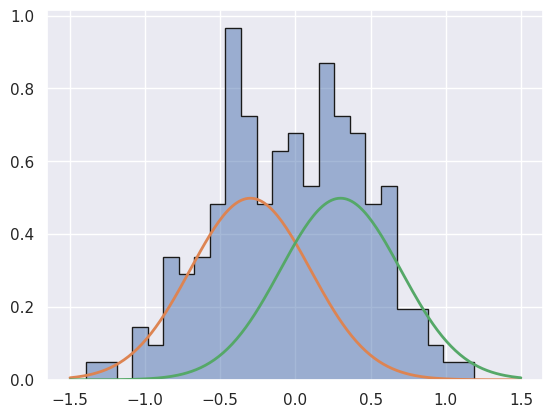

In [6]:
Dc = generate_mix(n_gen, 0.5, -0.3, 0.3, 0.4, 0.4)

Note that each sample has an integer number of entries drawn from each Gaussian, so the true `frac1` is only realized on average.

We will compare two models to explain this data:
 - M1: A single Gaussian with unknown mean $\mu$ and sigma $\sigma$.

 - M2: Two Gaussians with equal proportions (`frac1=0.5`), means with a fixed separation $\mu_2 - \mu_1 = 0.6$, and unknown sigmas $\sigma_1$, $\sigma_2$.
 
Note that `Da` is drawn from M1 and `Db`, `Dc` are drawn from M2.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">DISCUSS:</span>___ For each of these three datasets, predict whether the Bayes' factor for M1 relative to M2 will be:
 - Much larger than 1, i.e., strongly favoring M1.

 - About 1, i.e. unable to discriminate between M1 and M2 based on the data alone.

 - Much smaller than 1, i.e., strongly favoring M2.
 
Explain your reasoning.

`Da` should strongly favor M1 since the fixed separation of the M2 means makes it very unlikely to have been generated by M2.

`Db` should very strongly favor M2, since no reasonable statistical fluctuation of M1 would ever reproduce it.

`Dc` should be unable to discriminate between M1 and M2 since, although it was produced by M2, M1 might produce data like this with the right statistical fluctuations.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

[Jeffreys proposed a scale](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) for thresholds in the Bayes' factor:
 - larger than 100 is "decisive evidence" in favor of M1.

 - larger than 10 is "strong evidence" in favor of M1.

 - smaller than 0.1 is "strong evidence" in favor of M2.

 - smaller than 0.01 is "decisive evidence" in favor of M2.

To compare models for given data $D$, we perform the following steps for each candidate model $M$:
 - Perform a Bayesian inference with HMC assuming $M$ to obtain samples of $(\mu, \sigma)$ drawn from the posterior $P(\theta\mid D, M)$.

 - Construct a density estimate of the posterior using the generated samples.

 - Estimate the evidence $P(D\mid M)$ for $D$ given $M$ using the density estimate.

Once we have estimated the evidence for each model, we can calculate the Bayes' factor for any pair of models.

The final step is to assign relative prior probabilities for each model in order to calculate the odds ratios.

The following parameter ranges are enforced by setting the prior probability to zero outside these ranges:
 - M1: $|\mu| \le 1$ and $0.05 \le \sigma \le 1.0$.

 - M2: $|\mu| \le 1$ and $0.05 \le \sigma_i \le 1.0$, with $\mu \equiv (\mu_1 + \mu_2) / 2$.

In [7]:
mu_range = (-1., +1.)
sigma_range = (0.05, 1.0)
t_range = np.log(sigma_range)

The code below to calculate the evidence assuming M1 is quite involved, and brings together several topics we have met already:
 - Bayesian inference.

 - Tensorflow and scipy.stats frameworks.

 - Hamiltonian Markov-chain Monte Carlo.

 - Density estimation.

 - Evidence estimation with MCMC samples.
 
Do not worry about the details, at least until you need to perform a similar calculation yourself!

To build this calculation, first define the log-posterior PDFs of both models:

In [8]:
def M1_logpost(D, mu, t):
    # Perform change of variables.
    sigma = np.exp(t)
    # Apply priors on (mu, sigma)
    if np.abs(mu) > 1: return -np.inf
    if sigma < 0.05 or sigma > 1.0: return -np.inf
    # Calculate and return the log-likelihood.
    return scipy.stats.norm.logpdf(D, mu, sigma).sum()

In [9]:
def M2_logpost(D, mu, t1, t2):
    # Perform change of variables.
    mu1 = mu - 0.3
    mu2 = mu + 0.3
    sigma1 = np.exp(t1)
    sigma2 = np.exp(t2)
    # Apply priors on (mu, t1, t2)
    if np.abs(mu) > 1: return -np.inf
    if sigma1 < 0.05 or sigma1 > 1.0: return -np.inf    
    if sigma2 < 0.05 or sigma2 > 1.0: return -np.inf    
    # Calculate and return the log-likelihood.
    return np.log(0.5 * (
       scipy.stats.norm.pdf(D, mu1, sigma1) +
       scipy.stats.norm.pdf(D, mu2, sigma2))).sum()

Now we are ready to estimate the evidence for the observed data D assuming model M1:

In [10]:
def calculate_M1_evidence(D, n_mc=2000, n_grid=50, seed=123):
    # --------------------------------------------------------------------------
    # Pick intial point for MCMC chains based on the data.
    # --------------------------------------------------------------------------
    lo, med, hi = np.percentile(D, (16, 50, 84))
    mu_init = np.float32(med)
    t_init = np.float32(np.log(0.5 * (hi - lo)))
    # --------------------------------------------------------------------------
    # Use MCMC to generate samples from the M1 posterior.
    # --------------------------------------------------------------------------
    gen = np.random.RandomState(seed)
    samples = MCMC_sample(M1_logpost, D=D,
                          mu=[mu_init], t=[t_init],
                          nsamples=n_mc, random_state=gen)
    # Replace t=log(sigma) with sigma.
    samples['sigma'] = np.exp(samples['t'])
    samples.drop(columns='t', inplace=True)
    # --------------------------------------------------------------------------
    # Build a parameter grid for estimating the evidence.
    # --------------------------------------------------------------------------
    mu_grid = np.linspace(*np.percentile(samples['mu'], (0.5, 99.5)), n_grid)
    sigma_grid = np.linspace(*np.percentile(samples['sigma'], (0.5, 99.5)), n_grid)
    # --------------------------------------------------------------------------
    # Evaluate the posterior numerator P(D|mu,sigma) P(mu,sigma) on the grid.
    # --------------------------------------------------------------------------
    sigma_ = sigma_grid.reshape(-1, 1)
    D_ = D.reshape(-1, 1, 1)
    log_numerator_grid = scipy.stats.norm.logpdf(D_, mu_grid, sigma_).sum(axis=0)
    log_numerator_grid -= np.log(sigma_)
    # --------------------------------------------------------------------------
    # Estimate the posterior density from the generated samples with a GMM.
    # --------------------------------------------------------------------------
    fit = mixture.GaussianMixture(n_components=1).fit(samples.values)
    # --------------------------------------------------------------------------
    # Evaluate the density on the grid.
    # --------------------------------------------------------------------------
    log_density_grid = np.empty((n_grid, n_grid))
    for i1, mu_value in enumerate(mu_grid):
        for i2, sigma_value in enumerate(sigma_grid):
            log_density_grid[i2, i1] = fit.score_samples([[mu_value, sigma_value]])[0]
    # --------------------------------------------------------------------------
    # Use the the 25% of grid points with the largest numerator for the evidence estimate.
    # --------------------------------------------------------------------------
    log_numerator_cut = np.percentile(log_numerator_grid, 75)
    use = log_numerator_grid > log_numerator_cut
    log_evidence = np.median((log_numerator_grid - log_density_grid)[use])
    # --------------------------------------------------------------------------
    # Summarize the results with a plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(samples['mu'], samples['sigma'], s=5, lw=0, c='k')
    ax[0].contour(mu_grid, sigma_grid, np.max(log_numerator_grid) - log_numerator_grid,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[0].contour(mu_grid, sigma_grid, np.max(log_density_grid) - log_density_grid,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[0].set_xlim(mu_grid[0], mu_grid[-1])
    ax[0].set_ylim(sigma_grid[0], sigma_grid[-1])
    ax[0].set_xlabel('$\\mu$')
    ax[0].set_ylabel('$\\sigma$')
    ax[1].scatter(log_numerator_grid.flatten(),
                  (log_numerator_grid - log_density_grid).flatten(),
                  s=5, lw=0, c='r')
    ax[1].scatter(log_numerator_grid[use].flatten(),
                  (log_numerator_grid - log_density_grid)[use].flatten(),
                  s=5, lw=0, c='g')
    ax[1].axhline(log_evidence, c='g')
    ax[1].set_xlabel('$\\log P(D\\mid \\mu,\\sigma, M_1) + \\log P(\\mu,\\sigma\\mid M_1)$')
    ax[1].set_ylabel('$\\log P(D\\mid M_1)$')
    plt.subplots_adjust(wspace=0.25)
    return log_evidence

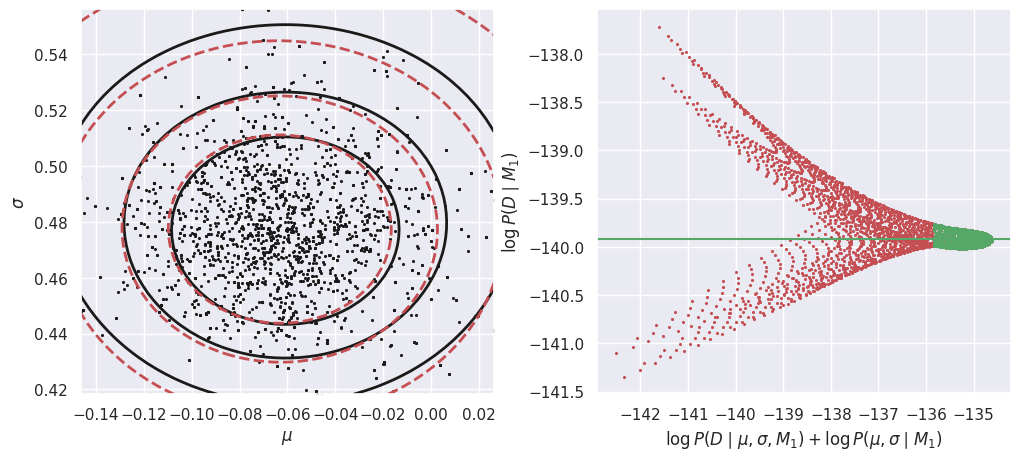

In [11]:
E_Da_M1 = calculate_M1_evidence(Da)

In the left-hand plot above, the solid black contours show the shape of the un-normalized posterior and the dashed red contours show the GMM density model fit to the MCMC samples. These do not need to agree exactly, but better agreement will lead to a more accurate estimate of the evidence $P(Da\mid M1)$.  In this example, we are using a GMM with a single component but the posterior is slightly non-Gaussian, so we could try increasing the number of MCMC samples and adding another GMM component.

The right-hand plot shows many independent estimates of the evidence, calculated as the ratio of the un-normalized posterior (solid black contours) and GMM density model (dashed red contours) on a uniform 2D grid of $(\mu, \sigma)$ points.  To combine these independent estimates, we take the median of the green values, where the posterior probability is largest (so this procedure should be more accurate). Review the [Markov Chain Montel Carlo notebook](https://illinois-ipaml.github.io/MachineLearningForPhysics/_sources/lectures/MarkovChainMonteCarlo.html) for a simpler 1D example of evidence estimation with the same approach.

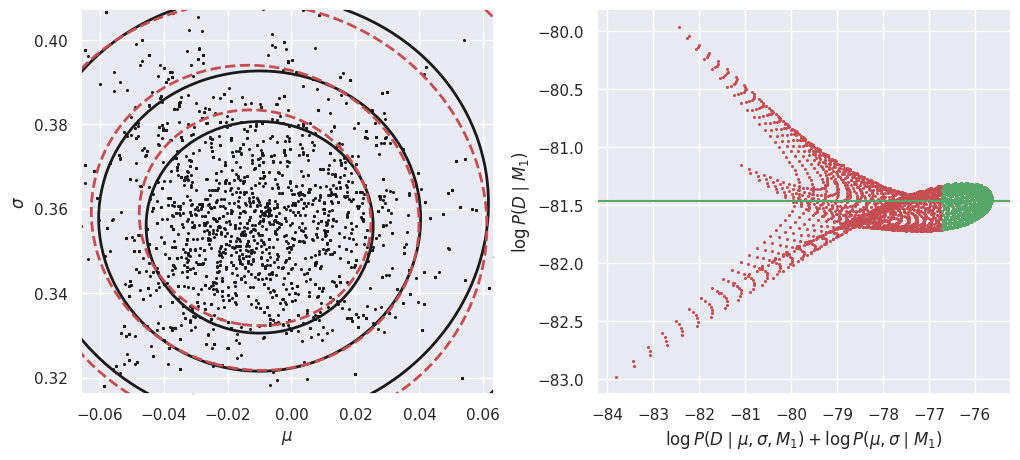

In [12]:
E_Db_M1 = calculate_M1_evidence(Db)

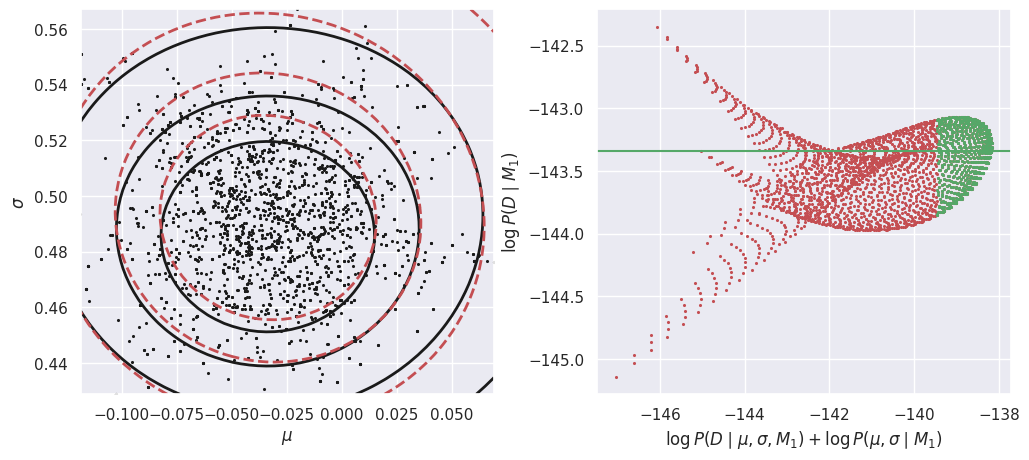

In [13]:
E_Dc_M1 = calculate_M1_evidence(Dc)

The calculation of the evidence for D assuming model M2 is very similar, but now in the 3D parameter space (mu, t1, t2):

In [14]:
def calculate_M2_evidence(D, n_mc=5000, n_grid=25, seed=123):
    # --------------------------------------------------------------------------
    # Pick starting point for MCMC chains based on the data.
    # --------------------------------------------------------------------------
    lo, med, hi = np.percentile(D, (16, 50, 84))
    mu_init = np.float32(med)
    t_init = np.float32(np.log(0.3 * (hi - lo)))
    # --------------------------------------------------------------------------
    # Use MCMC to generate samples from the M1 posterior.
    # --------------------------------------------------------------------------
    gen = np.random.RandomState(seed)
    samples = MCMC_sample(M2_logpost, D=D,
                          mu=[mu_init], t1=[t_init], t2=[t_init],
                          nsamples=n_mc, random_state=gen)
    # Replace ti=log(sigmai) with sigmai.
    samples['sigma1'] = np.exp(samples['t1'])
    samples['sigma2'] = np.exp(samples['t2'])
    samples.drop(columns='t1', inplace=True)
    samples.drop(columns='t2', inplace=True)
    # --------------------------------------------------------------------------
    # Build a parameter grid for estimating the evidence.
    # --------------------------------------------------------------------------
    mu_grid = np.linspace(*np.percentile(samples['mu'], (0.5, 99.5)), n_grid)
    sigma1_grid = np.linspace(*np.percentile(samples['sigma1'], (0.5, 99.5)), n_grid)
    sigma2_grid = np.linspace(*np.percentile(samples['sigma2'], (0.5, 99.5)), n_grid)
    # --------------------------------------------------------------------------
    # Evaluate the posterior numerator P(D|mu,sigma1,sigma2) P(mu,sigma1,sigma2) on the grid.
    # --------------------------------------------------------------------------
    mu1_, mu2_ = mu_grid - 0.3, mu_grid + 0.3
    sigma1_ = sigma1_grid.reshape(-1, 1)
    sigma2_ = sigma2_grid.reshape(-1, 1, 1)
    D_ = D.reshape(-1, 1, 1, 1)
    log_numerator_grid = np.log(0.5 * (
        scipy.stats.norm.pdf(D_, mu1_, sigma1_) +
        scipy.stats.norm.pdf(D_, mu2_, sigma2_))).sum(axis=0)
    log_numerator_grid -= np.log(sigma1_) + np.log(sigma2_)
    # --------------------------------------------------------------------------
    # Calculate projections onto each pair of parameters with numerical 1D integration.
    # --------------------------------------------------------------------------
    numerator_grid = np.exp(log_numerator_grid)
    proj_mu_sigma1 = np.log(np.trapezoid(numerator_grid, sigma2_grid, axis=0))
    proj_mu_sigma2 = np.log(np.trapezoid(numerator_grid, sigma1_grid, axis=1))
    proj_sigma1_sigma2 = np.log(np.trapezoid(numerator_grid, mu_grid, axis=2))
    # --------------------------------------------------------------------------
    # Estimate the posterior density from the generated samples with a GMM.
    # --------------------------------------------------------------------------
    fit = mixture.GaussianMixture(n_components=3).fit(samples.values)
    # --------------------------------------------------------------------------
    # Evaluate the density on the grid.
    # --------------------------------------------------------------------------
    log_density_grid = np.empty((n_grid, n_grid, n_grid))
    for i1, mu_value in enumerate(mu_grid):
        for i2, sigma1_value in enumerate(sigma1_grid):
            for i3, sigma2_value in enumerate(sigma2_grid):
                log_density_grid[i3, i2, i1] = fit.score_samples(
                    [[mu_value, sigma1_value, sigma2_value]])[0]
    # --------------------------------------------------------------------------
    # Calculate projections onto each pair of parameters with numerical 1D integration.
    # --------------------------------------------------------------------------
    density_grid = np.exp(log_density_grid)
    dproj_mu_sigma1 = np.log(np.trapezoid(density_grid, sigma2_grid, axis=0))
    dproj_mu_sigma2 = np.log(np.trapezoid(density_grid, sigma1_grid, axis=1))
    dproj_sigma1_sigma2 = np.log(np.trapezoid(density_grid, mu_grid, axis=2))
    # --------------------------------------------------------------------------
    # Use the the 5% of grid points with the largest numerator for the evidence estimate.
    # --------------------------------------------------------------------------
    log_numerator_cut = np.percentile(log_numerator_grid, 95)
    use = log_numerator_grid > log_numerator_cut
    log_evidence = np.median((log_numerator_grid - log_density_grid)[use])
    # --------------------------------------------------------------------------
    # Summarize the results with a plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax = ax.flatten()
    ax[0].scatter(samples['mu'], samples['sigma1'], s=3, lw=0, c='k')
    ax[0].contour(mu_grid, sigma1_grid, np.max(proj_mu_sigma1) - proj_mu_sigma1,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[0].contour(mu_grid, sigma1_grid, np.max(dproj_mu_sigma1) - dproj_mu_sigma1,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[0].set_xlim(mu_grid[0], mu_grid[-1])
    ax[0].set_ylim(sigma1_grid[0], sigma1_grid[-1])
    ax[0].set_xlabel('$\\mu$')
    ax[0].set_ylabel('$\\sigma_1$')
    ax[2].scatter(samples['mu'], samples['sigma2'], s=3, lw=0, c='k')
    ax[2].contour(mu_grid, sigma2_grid, np.max(proj_mu_sigma2) - proj_mu_sigma2,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[2].contour(mu_grid, sigma2_grid, np.max(dproj_mu_sigma2) - dproj_mu_sigma2,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[2].set_xlim(mu_grid[0], mu_grid[-1])
    ax[2].set_ylim(sigma2_grid[0], sigma2_grid[-1])
    ax[2].set_xlabel('$\\mu$')
    ax[2].set_ylabel('$\\sigma_2$')
    ax[3].scatter(samples['sigma1'], samples['sigma2'], s=3, lw=0, c='k')
    ax[3].contour(sigma1_grid, sigma2_grid, np.max(proj_sigma1_sigma2) - proj_sigma1_sigma2,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[3].contour(sigma1_grid, sigma2_grid, np.max(dproj_sigma1_sigma2) - dproj_sigma1_sigma2,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[3].set_xlim(sigma1_grid[0], sigma1_grid[-1])
    ax[3].set_ylim(sigma2_grid[0], sigma2_grid[-1])
    ax[3].set_xlabel('$\\sigma_1$')
    ax[3].set_ylabel('$\\sigma_2$')
    ax[1].scatter(log_numerator_grid.flatten(),
                  (log_numerator_grid - log_density_grid).flatten(),
                  s=5, lw=0, c='r')
    ax[1].scatter(log_numerator_grid[use].flatten(),
                  (log_numerator_grid - log_density_grid)[use].flatten(),
                  s=5, lw=0, c='g')
    ax[1].axhline(log_evidence, c='g')
    ax[1].set_xlabel('$\\log P(D\\mid \\mu,\\sigma_1,\\sigma_2, M_2) + \\log P(\\mu,\\sigma_1,\\sigma_2\\mid M_2)$')
    ax[1].set_ylabel('$\\log P(D\\mid M_2)$')
    plt.subplots_adjust(wspace=0.22)
    
    return log_evidence

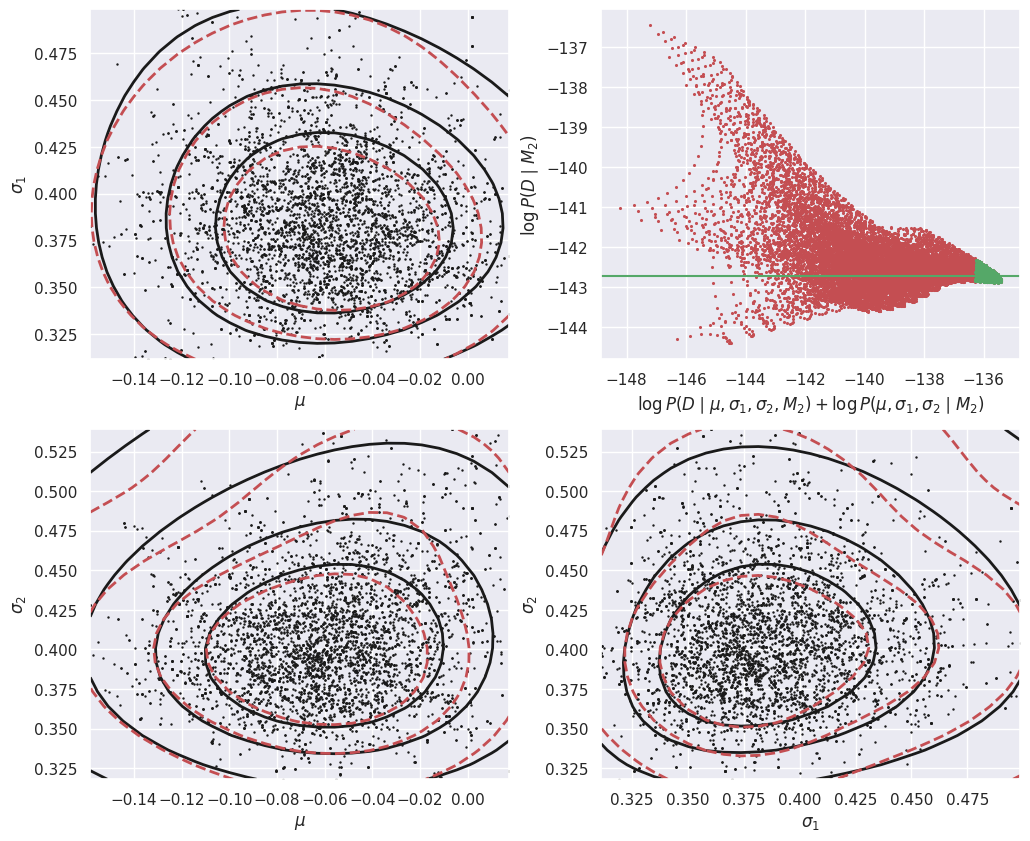

In [15]:
E_Da_M2 = calculate_M2_evidence(Da)

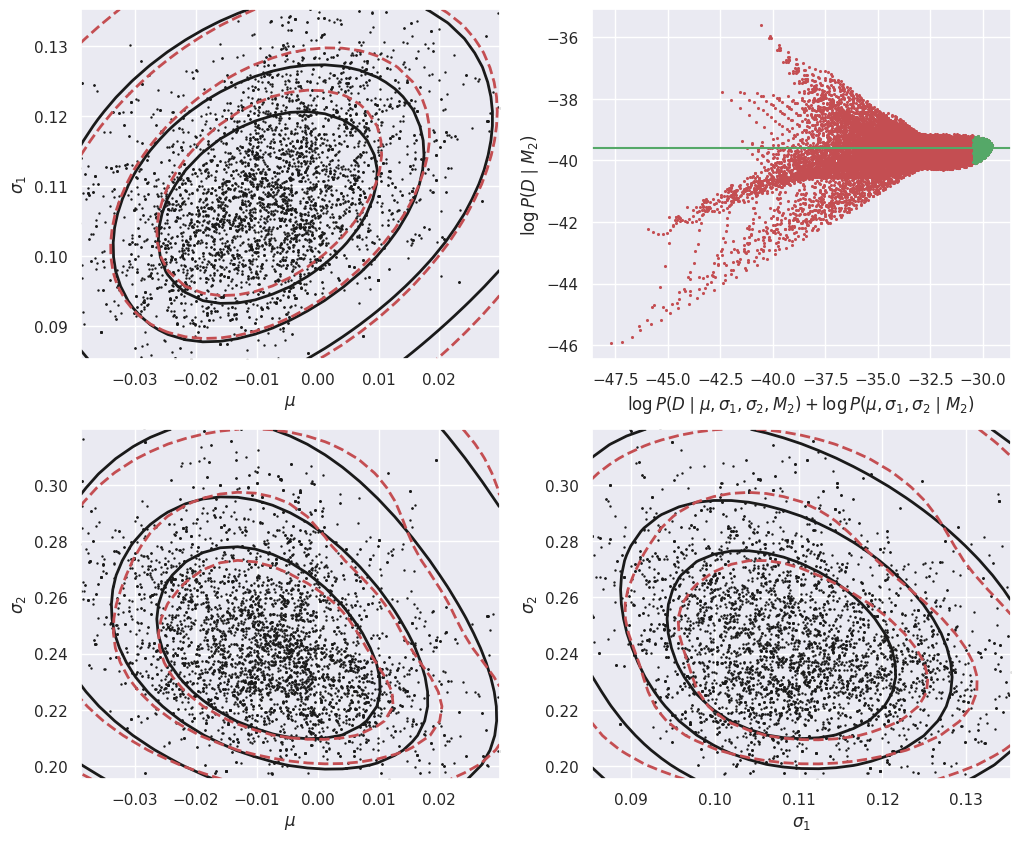

In [16]:
E_Db_M2 = calculate_M2_evidence(Db)

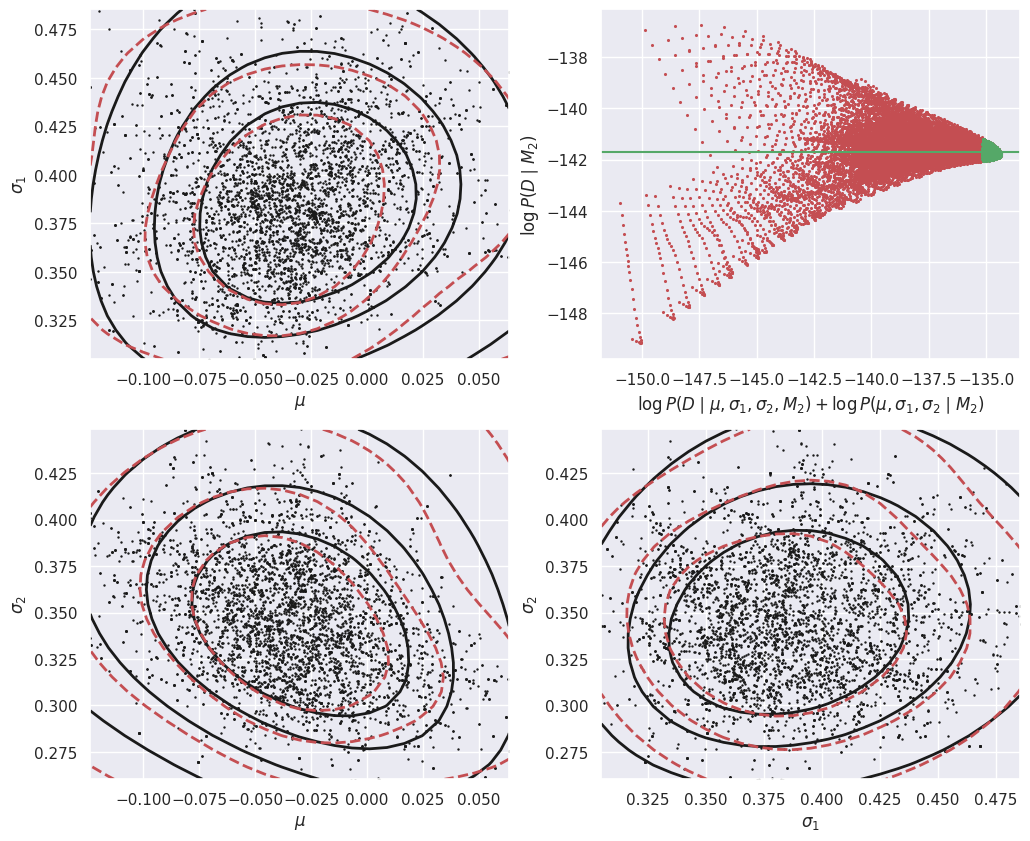

In [17]:
E_Dc_M2 = calculate_M2_evidence(Dc)

Each of these involved calculations provides a single number, the estimated log of the evidence for $D$ given $M$,

$$ \Large
\log P(D\mid M)
$$

Note these are tiny numbers ($e^{-100} \simeq 10^{-44}$), but it their difference that matters:

$$ \Large
\boxed{
\text{Bayes' factor} = \exp\left[ \log P(D\mid M_1) - \log P(D\mid M_2)\right] \;
}
$$

Finally, we apply our subjective prior weights for relative likelihood of M1 and M2 in the absence of any data to obtain the M1:M2 odds ratio:

$$ \Large
\boxed{
\frac{P(M_1\mid D)}{P(M_2\mid D)} = (\text{Bayes' factor}) \times \frac{P(M_1)}{P(M_2)} \;
}
$$

If we assume that M1 and M2 have equal a-priori weights, then the odds ratio equals the Bayes' factor:

In [18]:
def summarize(M1_prior=0.5, M2_prior=0.5):
    results = pd.DataFrame({
        'logM1': [E_Da_M1, E_Db_M1, E_Dc_M1],
        'logM2': [E_Da_M2, E_Db_M2, E_Dc_M2]},
        index=('Da', 'Db', 'Dc'))
    results['log10(Bayes)'] = (results['logM1'] - results['logM2']) / np.log(10.)
    results['log10(Odds)'] = results['log10(Bayes)'] + np.log10(M1_prior / M2_prior)
    return results.round(1)
    
summarize()

,logM1,logM2,log10(Bayes),log10(Odds)
Da,-139.9,-142.7,1.2,1.2
Db,-81.5,-39.6,-18.2,-18.2
Dc,-143.3,-141.7,-0.7,-0.7


To summarize in words:
 - M1 is "strongly" (but not "decisively") supported by `Da`.

 - M2 is "decisively" supported by `Db`

 - M2 is mildy supported by `Dc`, but the evidence is not "strong".

If we have a prior bias that M1 is 10x more likely than M1, this would mostly affect our assessment for `Dc`, which now slightly prefers M1:

In [19]:
summarize(M1_prior=10, M2_prior=1)

,logM1,logM2,log10(Bayes),log10(Odds)
Da,-139.9,-142.7,1.2,2.2
Db,-81.5,-39.6,-18.2,-17.2
Dc,-143.3,-141.7,-0.7,0.3


## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2026